In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,7)})

In [2]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [3]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [4]:
data.index = data.index[::-1]

In [5]:
data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],
           dtype='int64', length=5000)

In [6]:
# Попробуем вариант что у нас ежедневный прогноз считаем что у нас на выходных стабильная цена.
for i in data.index:
    if i > 0:
        data

In [7]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [8]:
#change indexes
special_data.set_index('Date', inplace = True)

In [9]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [10]:
special_data.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%
2010-01-11,1146.98,1145.96,1149.74,1142.02,NaN,0.17%
2010-01-12,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%
2010-01-13,1145.68,1137.31,1148.40,1133.18,NaN,0.83%
2010-01-14,1148.46,1145.68,1150.41,1143.80,NaN,0.24%


In [11]:
special_data['new_index'] = special_data.Price
special_data['new_date'] = special_data.Price
special_data.head()

,Price,Open,High,Low,Vol.,Change %,new_index,new_date
Date,,,,,,,,
2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1132.99,1132.99
2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1136.52,1136.52
2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1137.14,1137.14
2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1141.69,1141.69
2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1144.98,1144.98


In [13]:
import datetime

special_data.new_index[0] = 1262563200
special_data.new_date[0] = datetime.datetime.fromtimestamp(special_data.new_index[0]).strftime('%Y-%m-%d %H:%M:%S')
for i in range(len(special_data.new_index)):
    if i > 0:
        special_data.new_index[i] = special_data.new_index[i - 1] + 86400
        special_data.new_date[i] = datetime.datetime.fromtimestamp(special_data.new_index[i]).strftime('%Y-%m-%d %H:%M:%S')

In [14]:
#change indexes
special_data.set_index('new_date', inplace=True)

In [15]:
special_data.head(20)

,Price,Open,High,Low,Vol.,Change %,new_index
new_date,,,,,,,
2010-01-04 07:00:00,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1.262563e+09
2010-01-05 07:00:00,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1.262650e+09
2010-01-06 07:00:00,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1.262736e+09
2010-01-07 07:00:00,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1.262822e+09
2010-01-08 07:00:00,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1.262909e+09
2010-01-09 07:00:00,1146.98,1145.96,1149.74,1142.02,NaN,0.17%,1.262995e+09
2010-01-10 07:00:00,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%,1.263082e+09
2010-01-11 07:00:00,1145.68,1137.31,1148.40,1133.18,NaN,0.83%,1.263168e+09
2010-01-12 07:00:00,1148.46,1145.68,1150.41,1143.80,NaN,0.24%,1.263254e+09


In [16]:
print(special_data.index.inferred_freq)

AttributeError: 'Index' object has no attribute 'inferred_freq'

In [17]:
special_data.set_index('new_index', inplace = True)

In [18]:
special_data.head(20)

,Price,Open,High,Low,Vol.,Change %
new_index,,,,,,
1.262563e+09,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1.262650e+09,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
1.262736e+09,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
1.262822e+09,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
1.262909e+09,1144.98,1140.52,1145.39,1136.22,NaN,0.29%
1.262995e+09,1146.98,1145.96,1149.74,1142.02,NaN,0.17%
1.263082e+09,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%
1.263168e+09,1145.68,1137.31,1148.40,1133.18,NaN,0.83%
1.263254e+09,1148.46,1145.68,1150.41,1143.80,NaN,0.24%


In [19]:
f = Forecaster(y = special_data['Price'], current_dates = special_data.index)

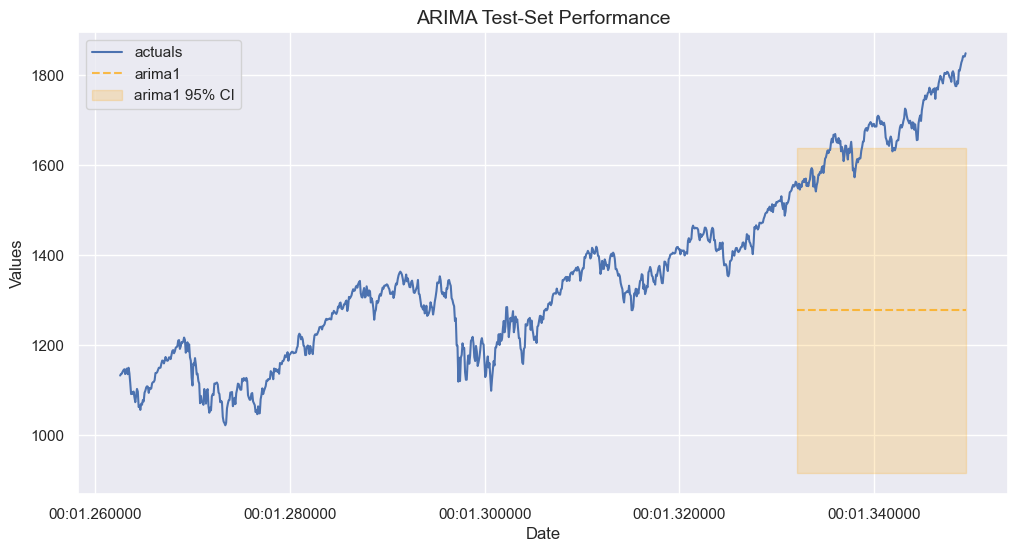

In [20]:
f.generate_future_dates(100) # 12-month forecast horizon
f.set_test_length(.2) # 20% test set
f.set_estimator('arima') # set arima
f.manual_forecast(call_me='arima1') # forecast with arima

f.plot_test_set(ci=True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

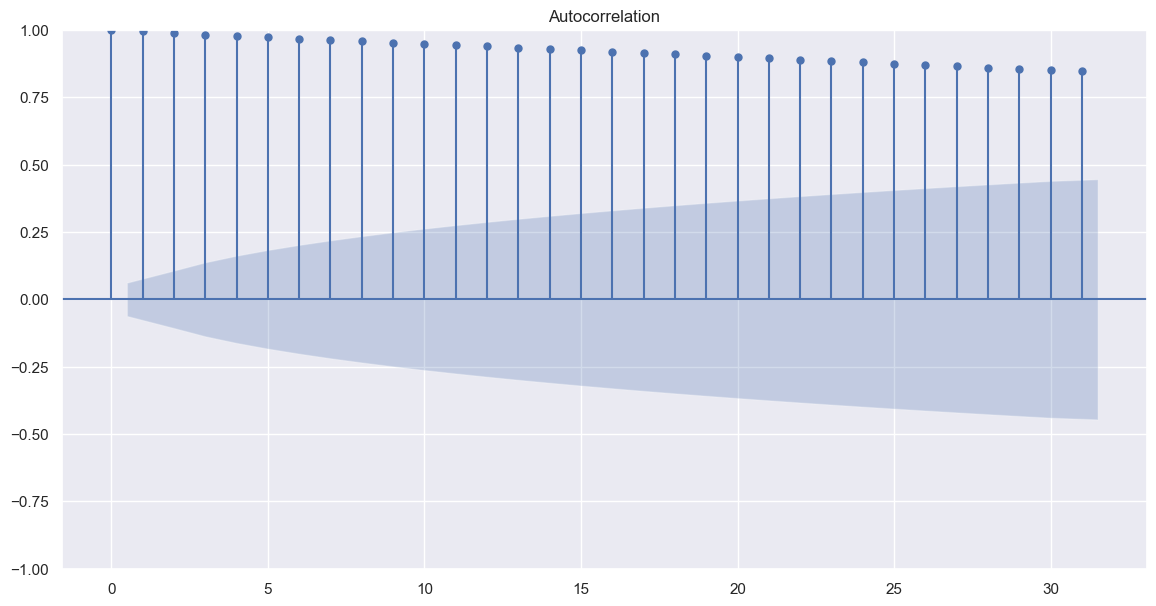

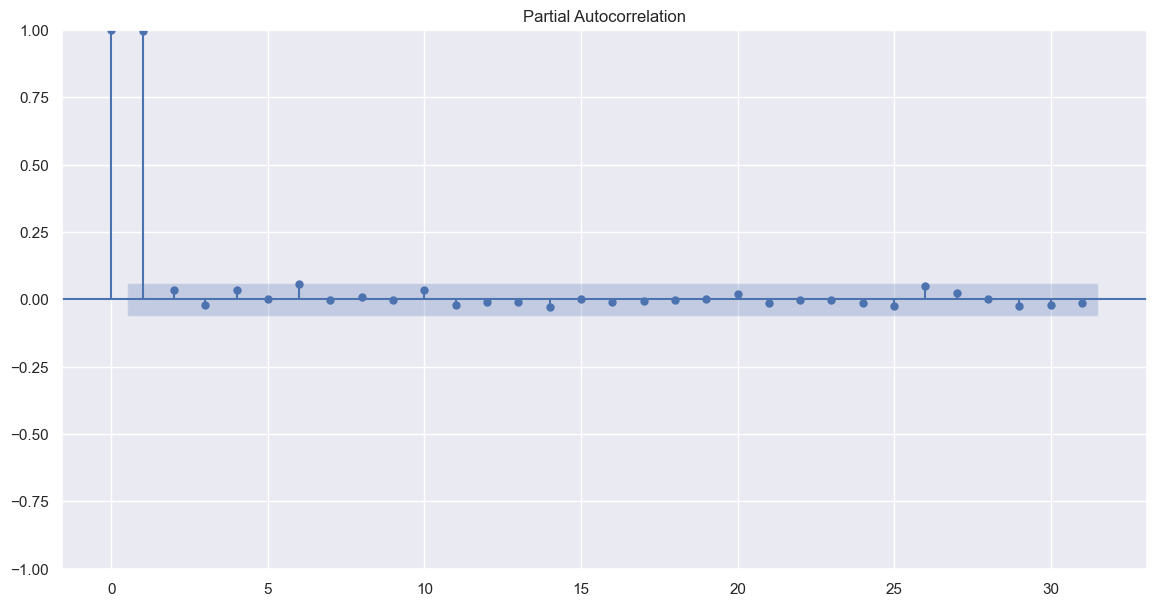

ValueError: freq N not understood. Please report if you think this is in error.

In [21]:
# EDA
f.plot_acf()
plt.show()
f.plot_pacf()
plt.show()
f.seasonal_decompose().plot()
plt.show()
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

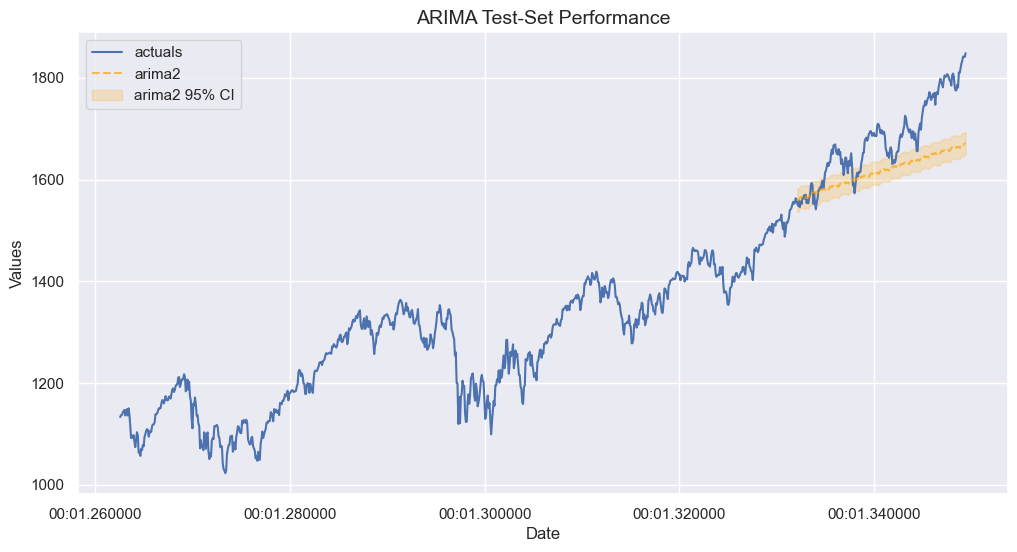

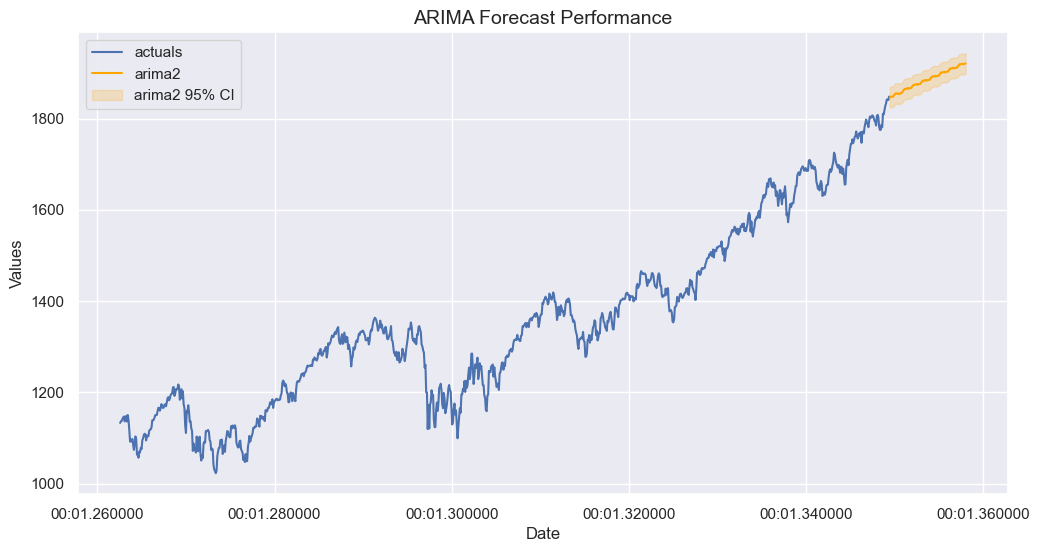

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                 1006
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -4013.507
Date:                          Sun, 02 Jul 2023   AIC                           8041.014
Time:                                  17:47:10   BIC                           8075.319
Sample:                                       0   HQIC                          8054.056
                                         - 1006                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8060      0.101     -7.991      0.000      -1.004      -0.608
ar.L2          0.0186      0.032      0.589      0.556      -0.043       0.080
ma.L1          0.7569      0.097      7.780      0.000       0.566       0.948
ar.S.L12      -0.0060      0.029     -0.204      0.838      -0.064       0.052
ar.S.L24       0.0440      0.033      1.345      0.179      -0.020       0.108
ma.S.L12      -0.9911      0.042    -23.693      0.000      -1.073      -0.909
sigma2       181.3901      8.487     21.372      0.000     164.755     198.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               253.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.33
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Forecast
f.manual_forecast(order=(2,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

# View test results
f.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

# View forecast results
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

# See summary stats
f.regr.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=6516.582, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6517.281, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6517.793, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6518.058, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6516.458, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6519.209, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=6519.214, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6521.052, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6515.901, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6517.801, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6519.641, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=6516.370, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6510.960, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=6512.934, Time=0.45 sec
 ARIMA(1,1,1)(0,0,1

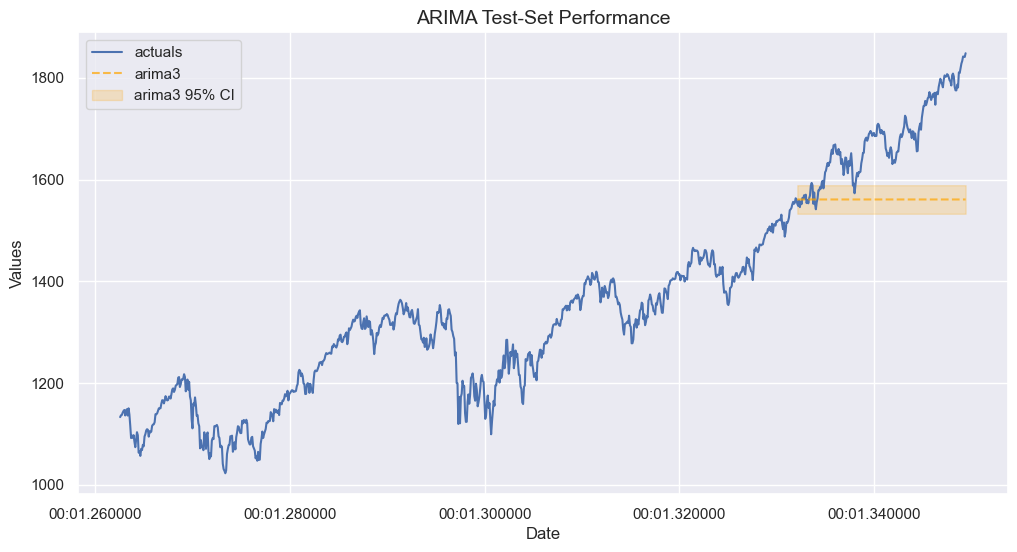

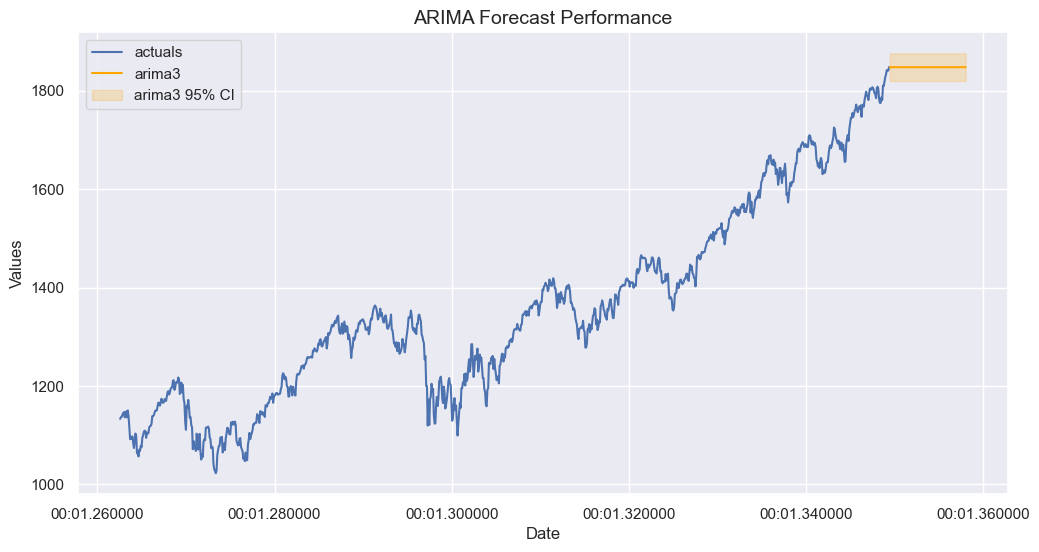

In [23]:
from scalecast.auxmodels import auto_arima

auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2, 
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [24]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4035.755
Date:                Sun, 02 Jul 2023   AIC                           8077.510
Time:                        17:47:16   BIC                           8092.248
Sample:                             0   HQIC                          8083.110
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8444      0.066    -12.706      0.000      -0.975      -0.714
ma.L1          0.7846      0.078     10.119      0.000       0.633       0.937
sigma2       180.0879      5.647     31.892      0.000     169.021     191.155
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               284.21
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.40
Prob(H) (two-sided):                  0.23   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

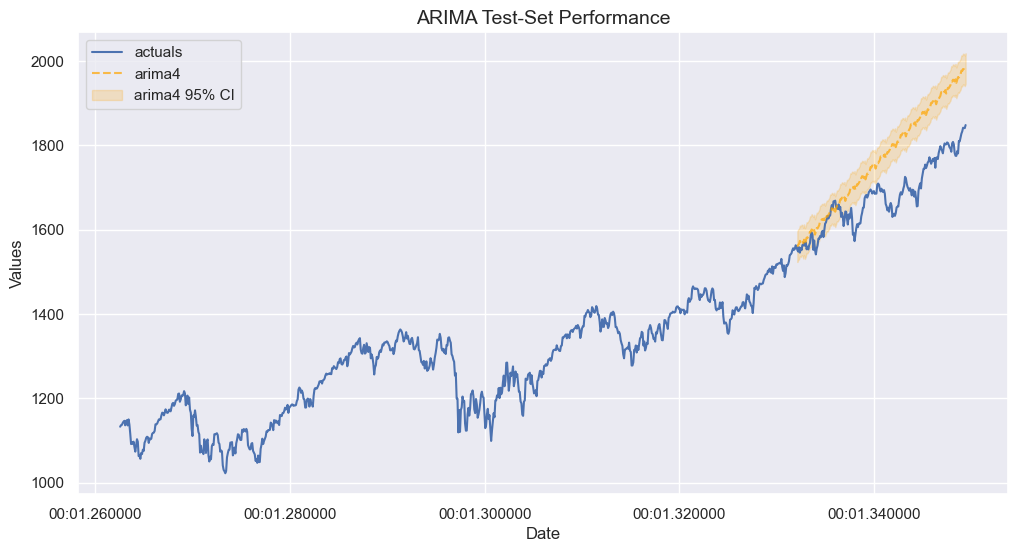

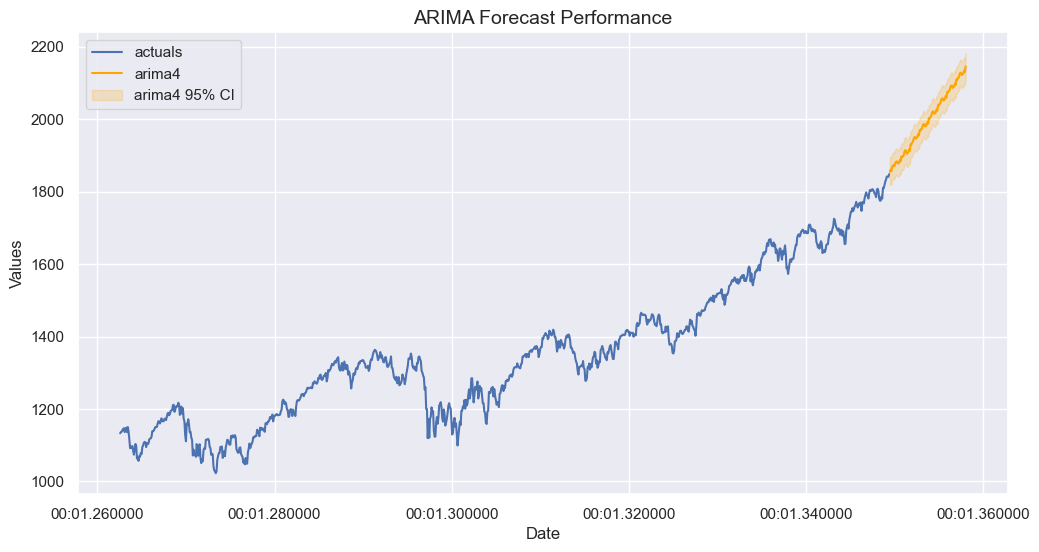

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1006
Model:             ARIMA(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -4128.370
Date:                           Sun, 02 Jul 2023   AIC                           8266.740
Time:                                   17:47:34   BIC                           8291.244
Sample:                                        0   HQIC                          8276.057
                                          - 1006                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8405      0.072    -11.646      0.000      -0.982      -0.699
ma.L1          0.7752      0.084      9.254      0.000       0.611       0.939
ar.S.L12      -0.6880      0.028    -24.779      0.000      -0.742      -0.634
ar.S.L24      -0.3141      0.027    -11.620      0.000      -0.367      -0.261
sigma2       237.6471      7.673     30.973      0.000     222.609     252.685
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               227.13
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.25
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=True,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

In [26]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [27]:
summaries = results['model_summaries']
summaries[
    [
         'ModelNickname',
         'HyperParams',
         'InSampleMAPE',
         'TestSetMAPE'
    ]
]

,ModelNickname,HyperParams,InSampleMAPE,TestSetMAPE
0,arima2,"{'order': (2, 1, 1), 'seasonal_order': (2, 1, 1, 12)}",0.009163,0.037620
1,arima4,"{'order': (1, 1, 1), 'seasonal_order': (2, 1, 0, 12)}",0.010164,0.053786
2,arima3,"{'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 12), 'trend': None}",0.008407,0.068865
3,arima1,{},0.117585,0.237339
